In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import ee
ee.Initialize()

In [2]:
country_area_dict = {
    'Kenya': 0.002827789841332337,
    'Liberia': 0.12124025090296826,
    'Ethiopia': 0.001977555390952114,
    'Zambia': 0.022979913519226184,
    'Paraguay': 0.04869386760668971,
    'Guyana': 0.005261059806840681,
    'Ghana': 0.03701879621995561,
    'Cambodia': 0.05971604821771966,
    'Bangladesh': 0.011510836027121663
}

In [3]:
# period of change
start_year = 2015
end_year = 2020

# forest definition
tree_cover = 20         # in percent
mmu = 0.5               # in hectare

# aoi (various options)

# based on earth engine feature collection
country = 'Papua New Guinea'
gaul = ee.FeatureCollection("FAO/GAUL/2015/level1")
aoi = gaul.filter(ee.Filter.eq("ADM0_NAME", country)).union()

def get_aoi_areas(aoi, collection, start=2001, end=2022, tree_cover=20, mmu=0.5):
    
    if collection == 'CCI':

        lc = ee.ImageCollection("users/amitghosh/sdg_module/esa/cci_landcover")
        lc_start = lc.filter(ee.Filter.eq("system:index", f'{start}')).first()
        lc_end = lc.filter(ee.Filter.eq("system:index", f'{end}')).first()
        change = lc_start.neq(lc_end).clip(aoi)
        scale = 300

    elif collection == 'GFC':
        
        scale = 30
        hansen = ee.Image("UMD/hansen/global_forest_change_2021_v1_9")
        loss = hansen.select('lossyear').unmask(0)
        change = loss.gte(ee.Number(start).subtract(2000)).And(loss.lte(ee.Number(end).subtract(2000)))
        forest = hansen.select('treecover2000').updateMask(
            loss.gte(ee.Number(start).subtract(2000)).Or(loss.eq(0))
        ).gte(tree_cover).unmask(0)
        
        
    # -----------------------------------------------------------------
    # getting total area of change
    total_image = forest.addBands(change).addBands(ee.Image(1)).multiply(ee.Image.pixelArea()).rename(['forest_area', 'change_area', 'total_area'])
    areas = total_image.reduceRegion(**{
            'reducer': ee.Reducer.sum(),
            'geometry': aoi,
            'scale': scale,
            'maxPixels': 1e14
        })
    
    
    d, areas = {}, areas.getInfo()
    for area in areas.keys():
        d[area] = np.round(areas[area]/1000000,2)
    
    span = end-start+1
    print(f"According to the GFC product, the Area of Interest covers an area of {d['total_area']} square kilometers,"
          f" of which {d['forest_area']} square kilometers have been forested in {start} ({np.round(d['forest_area']/d['total_area']*100, 2)} %)."
          f" Between {start} and {end}, {d['change_area']} square kilometers have been deforested."
          f" That corresponds to {d['change_area']/span} square kilometers of annual deforestation in average."    
    )
    
    return d

area_dict = get_aoi_areas(aoi, 'GFC', start_year, end_year, tree_cover)

According to the GFC product, the Area of Interest covers an area of 462229.02 square kilometers, of which 422895.73 square kilometers have been forested in 2015 (91.49 %). Between 2015 and 2020, 7826.18 square kilometers have been deforested. That corresponds to 1304.3633333333335 square kilometers of annual deforestation in average.


In [4]:
# we should invert that to do something similar as extrating from global data
def calculate_error_cochran(total_area, subarea, z_score=1.96, sample_size=250):
    
    proportional_change = subarea/total_area
    se = np.sqrt(proportional_change * (1 - proportional_change) / sample_size)
    ci = z_score * se
    return ci/proportional_change*100

In [8]:
from pathlib import Path

def add_stats(row, actual_proportional):
    
    abs_errors = [np.abs(np.subtract(i, actual_proportional)) for i in row['proportional_changes_sampled']]
    mean_deviation, sd_deviation = np.nanmean(abs_errors), np.nanstd(abs_errors)
    
    mean_area = np.nanmean(row['proportional_changes_sampled'])
    sds = [np.sqrt(p*(1-p)) for p in row['proportional_changes_sampled']]
    mean_sd = np.nanmean(sds)
    se_area = np.divide(mean_sd, np.sqrt(len(row['proportional_changes_sampled'])))
    
    #sd_area = np.nanstd(row['proportional_changes_sampled'])
    #se_area = np.divide(sd_area, np.sqrt(len(row['proportional_changes_sampled'])))
    #se_area = np.divide(sd_area, np.sqrt(row['sample_size']))
    
    ci = 1.96 * se_area
    perc_uncertainty = ci/mean_area*100
    
    return mean_deviation, sd_deviation, mean_area, mean_sd, se_area, perc_uncertainty

df = False
df_coch = pd.DataFrame(columns = ['country', 'spacing', 'sample_size', 'proportional_changes_sampled', 'perc_uncertainty', 'scale'])
grid_sizes = [500, 1000, 2000, 4000, 7500, 10000]

for country in ['Ethiopia', 'Liberia', 'Kenya', 'Paraguay', 'Guyana', 'Zambia']:
    
    actual_proportion = country_area_dict[country]
    gaul = ee.FeatureCollection("FAO/GAUL/2015/level1")
    aoi = gaul.filter(ee.Filter.eq("ADM0_NAME", country)).union()
    area_dict = get_aoi_areas(aoi, 'GFC', start_year, end_year, tree_cover)
    
    for spacing in grid_sizes:
    
        sample_size = area_dict['total_area']*1000000/(spacing**2)
        cochran_error = calculate_error_cochran(area_dict['total_area'], area_dict['change_area'], z_score=1.96, sample_size=sample_size)
        df_coch.loc[len(df_coch)] = [country, spacing, sample_size, area_dict['change_area']/area_dict['total_area'], cochran_error, 'cochran']
        
        
    for scale in [30 , 70, 100, 250]:
        
        if df is False: 
            df = pd.read_pickle(f'{country}_25_runs_{scale}_scale.pickle')
            df[['mean_bias', 'sd_bias', 'mean_area', 'sd_area', 'se_area', 'perc_uncertainty']] = df.apply(
                    lambda x: add_stats(x, actual_proportion), axis=1, result_type='expand'
                )
            df['scale'] = scale
            df['country'] = country
            continue
        else:
            if Path(f'{country}_25_runs_{scale}_scale.pickle').exists():
                #print('there', country, scale)
                df_new = pd.read_pickle(f'{country}_25_runs_{scale}_scale.pickle')

                df_new[['mean_bias', 'sd_bias', 'mean_area', 'sd_area', 'se_area', 'perc_uncertainty']] = df_new.apply(
                    lambda x: add_stats(x, actual_proportion), axis=1, result_type='expand'
                )

                df_new['scale'] = scale
                df_new['country'] = country
                df = pd.concat([df, df_new])

    df = pd.concat([df, df_coch])

According to the GFC product, the Area of Interest covers an area of 1129313.5 square kilometers, of which 195968.7 square kilometers have been forested in 2015 (17.35 %). Between 2015 and 2020, 2233.28 square kilometers have been deforested. That corresponds to 372.21333333333337 square kilometers of annual deforestation in average.


/tmp/ipykernel_15076/1288091498.py:18: RuntimeWarning: invalid value encountered in double_scalars
  perc_uncertainty = ci/mean_area*100


According to the GFC product, the Area of Interest covers an area of 96102.49 square kilometers, of which 87243.03 square kilometers have been forested in 2015 (90.78 %). Between 2015 and 2020, 11651.49 square kilometers have been deforested. That corresponds to 1941.915 square kilometers of annual deforestation in average.


/tmp/ipykernel_15076/1288091498.py:18: RuntimeWarning: invalid value encountered in double_scalars
  perc_uncertainty = ci/mean_area*100


According to the GFC product, the Area of Interest covers an area of 582341.72 square kilometers, of which 48746.96 square kilometers have been forested in 2015 (8.37 %). Between 2015 and 2020, 1646.74 square kilometers have been deforested. That corresponds to 274.45666666666665 square kilometers of annual deforestation in average.


/tmp/ipykernel_15076/1288091498.py:18: RuntimeWarning: invalid value encountered in double_scalars
  perc_uncertainty = ci/mean_area*100


According to the GFC product, the Area of Interest covers an area of 399366.1 square kilometers, of which 214522.58 square kilometers have been forested in 2015 (53.72 %). Between 2015 and 2020, 19446.68 square kilometers have been deforested. That corresponds to 3241.1133333333332 square kilometers of annual deforestation in average.


/tmp/ipykernel_15076/1288091498.py:18: RuntimeWarning: invalid value encountered in double_scalars
  perc_uncertainty = ci/mean_area*100


According to the GFC product, the Area of Interest covers an area of 211721.6 square kilometers, of which 190410.72 square kilometers have been forested in 2015 (89.93 %). Between 2015 and 2020, 1113.88 square kilometers have been deforested. That corresponds to 185.64666666666668 square kilometers of annual deforestation in average.


/tmp/ipykernel_15076/1288091498.py:18: RuntimeWarning: invalid value encountered in double_scalars
  perc_uncertainty = ci/mean_area*100


According to the GFC product, the Area of Interest covers an area of 751066.36 square kilometers, of which 384975.25 square kilometers have been forested in 2015 (51.26 %). Between 2015 and 2020, 17259.44 square kilometers have been deforested. That corresponds to 2876.5733333333333 square kilometers of annual deforestation in average.


/tmp/ipykernel_15076/1288091498.py:18: RuntimeWarning: invalid value encountered in double_scalars
  perc_uncertainty = ci/mean_area*100


In [ ]:
df.head(5)

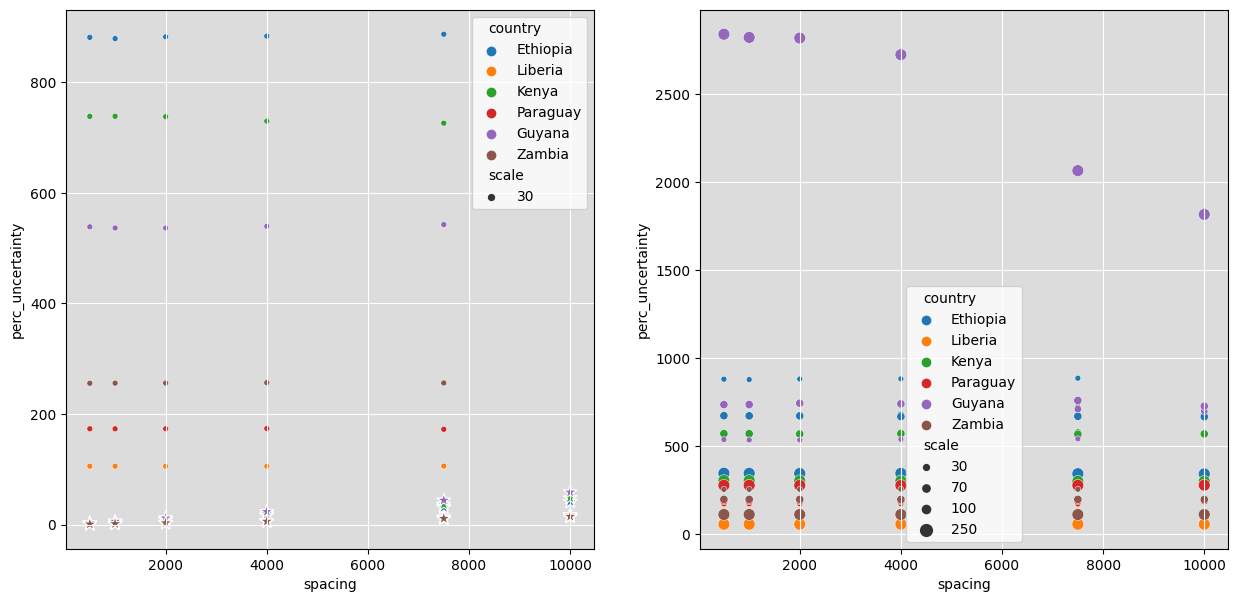

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
#df.plot.scatter(y='proportional_error', x='spacing', ax=axes[0], color='country')
axes[0] = sns.scatterplot(data=df[df['scale'] == 30], x='spacing', y='perc_uncertainty', hue='country', size='scale', ax=axes[0])
axes[0] = sns.scatterplot(data=df[df['scale'] == 'cochran'], x='spacing', y='perc_uncertainty', marker='*', s=100, hue='country', ax=axes[0], legend=False)
#df.plot.scatter(y='Theoretical Sampling Error (Deforestation)', x='Sample Size', ax=axes[0], color='orange')
#selected.plot.scatter(y='Theoretical Sampling Error (Deforestation)', x='Sample Size', ax=axes[0], color='blue')
#axes[0].legend(['Forest stable', 'Forest Change', 'Selected'])
#df.plot(kind='scatter', x='Sample Size', y='Grid Size', ax=axes[1],color='white')
#selected.plot(kind='scatter', x='Sample Size', y='Grid Size', ax=axes[1], color='blue')

axes[1] = sns.scatterplot(data=df[df['scale'] != 'cochran'], x='spacing', y='perc_uncertainty', hue='country', size='scale', ax=axes[1])
axes[0].set_facecolor("gainsboro")
axes[0].grid(color='white')
axes[1].set_facecolor("gainsboro")
axes[1].grid(color='white')

#axes[1].set_facecolor("gainsboro")
#axes[1].grid()